In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from pathlib import Path

import altair as alt
from altair.expr import datum

In [2]:
%load_ext watermark

In [3]:
%watermark --iversions

xarray    0.12.0
altair    3.0.1
numpy     1.16.3
pandas    0.24.2



# 0. Utility functions

In [4]:
from utils.load import load_ko_data
from utils.calculate_metrics import (process_data, relative_errors, summary_errors)

# 1. Load the simulation data

In [5]:
ko_df, debug_info = load_ko_data()

In [6]:
ko_df.head()

,flux,ID,BiGG_ID,author,sample_id,normalized_flux
0,-0.059225,ACALD,ACALD,Khodayari,fbaA,-0.059127
1,-0.004108,ACALDtpp_ex,composed of ACALDtex and ACALDtpp,Khodayari,fbaA,-0.004101
2,0.000028,ACKr,ACKr,Khodayari,fbaA,0.000028
3,94.519769,ACONTa,ACONTa,Khodayari,fbaA,94.364274
4,94.276304,ACONTb,ACONTb,Khodayari,fbaA,94.121209


### Preprocess data

In [7]:
xdf = process_data(ko_df, author="Ishii")

# 2. Calculate error metrics

In [8]:
x_rel_error = relative_errors(xdf, author="Ishii")

In [9]:
x_norm_error = summary_errors(xdf, author="Ishii")

# 3. Visualize

### Summary normalized error for the models

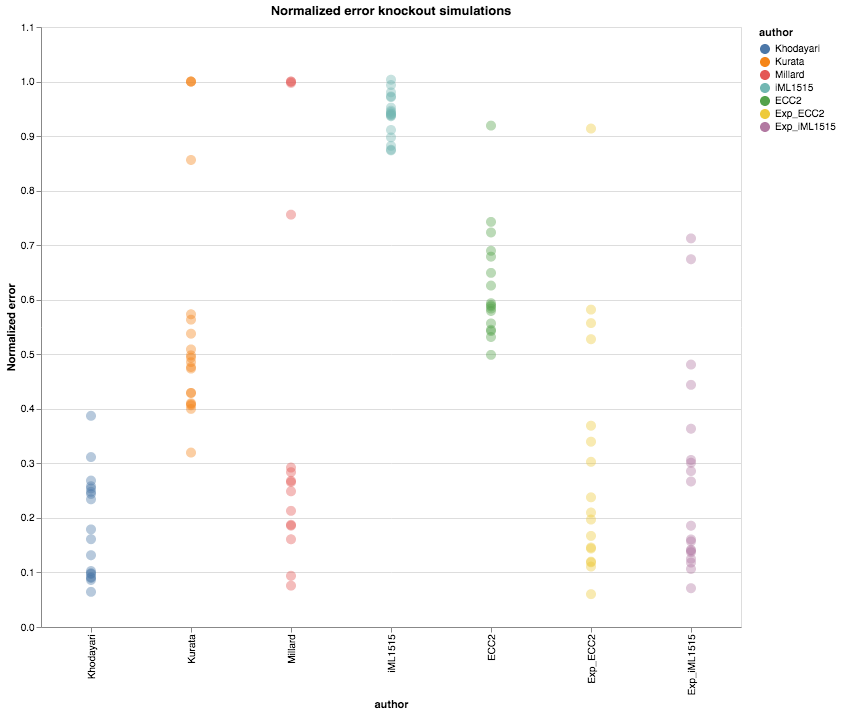

In [10]:
selector = alt.selection_single(empty="all", fields=["sample_id"])
color = alt.condition(
    selector,
    alt.Color(
        "author:N",
        sort=[
            "Khodayari",
            "Kurata",
            "Millard",
            "iML1515",
            "Ec_core",
            "ECC2",
            "Exp_ECC2",
        ],
    ),
    alt.ColorValue("lightgray"),
)

opacity = alt.condition(selector, alt.OpacityValue(0.4), alt.OpacityValue(1.0))

size = alt.condition(selector, alt.SizeValue(100), alt.SizeValue(40))


base = (
    alt.Chart(
        x_norm_error.to_dataframe()
        .reset_index()
        .query("author != 'Ishii'"),
        title="Normalized error knockout simulations",
    )
    .mark_circle()
    .encode(
        y=alt.Y("normalized_error", title="Normalized error"),
        tooltip=["author", "sample_id", "normalized_error"],
        x=alt.X("author", sort=["Khodayari", "Kurata", "Millard", "iML1515"]),
        size=size,
        opacity = opacity,
    )
)

errors = (
    base
    .encode(color=color)
    .add_selection(selector)
    .transform_filter("datum.normalized_error !== null")
)

na_vals = base.encode(color=alt.value("lightgrey")).transform_filter("datum.normalized_error === null")


(errors).properties(width=700, height=600).configure_axis(
    labelFontSize=24, titleFontSize=24
).configure_legend(labelFontSize=16, titleFontSize=20).configure(invalidValues=None)


In [10]:
from utils.vis import heatmap, summary_chart

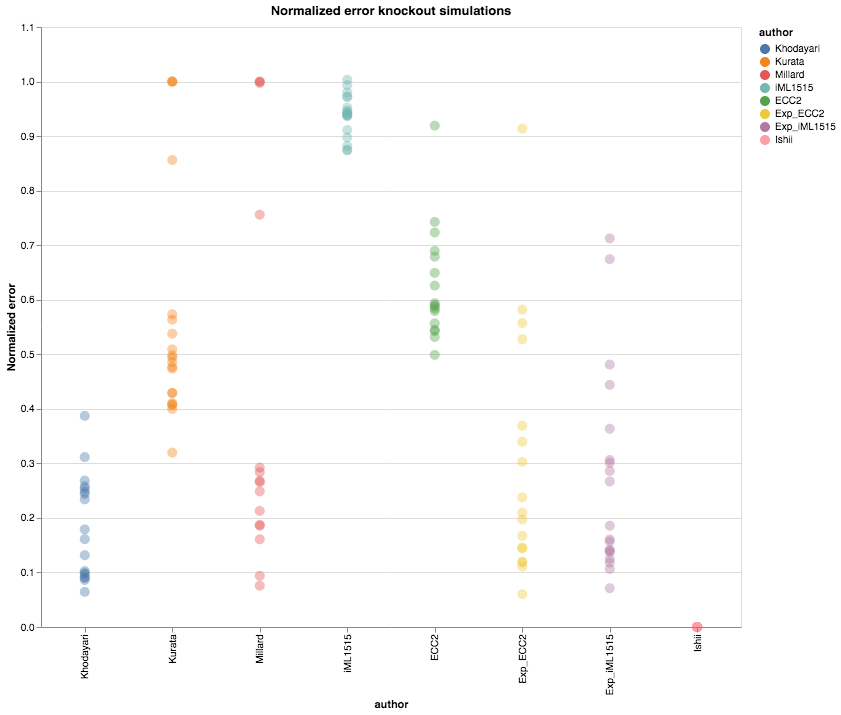

In [12]:
summary_chart(norm_error=x_norm_error,
              author="Ishii",
              title="Normalized error knockout simulations",
              sort_list=["Khodayari", "Kurata", "Millard", "iML1515"])

In [11]:
def heatmap(xdf, author=None, sample_id=None):
    data = xdf['relative_error'].to_dataframe().reset_index()
    if sample_id:
        data = data.query(f"sample_id == '{sample_id}'")
        title = f"Heatmap for sample_id {sample_id}"
    else:
        data = data.query(f"author == '{author}'")
        title = f"Heatmap for author {author}"

    base = (
        alt.Chart(data, title=title)
        .mark_rect()
        .encode(
            y=alt.Y("BiGG_ID:N"),
            color=alt.condition(
                "datum.relative_error === null",
                alt.ColorValue("lightgrey"),
                alt.Color(
                    "relative_error",
                    scale=alt.Scale(
                        domain=[0, 25, 50, 75, 100, 200, 300], type="threshold", scheme="greenblue",
                    ),
                    title = "relative error (clipped at 300)"
                ),
            ),
            tooltip=["sample_id", "BiGG_ID", "relative_error"],
        )
    )
    if sample_id:
        chart = base.encode(x=alt.X("author:N"))
    else:
        chart = base.encode(x=alt.X("sample_id:N"))

    return chart.configure(invalidValues=None)

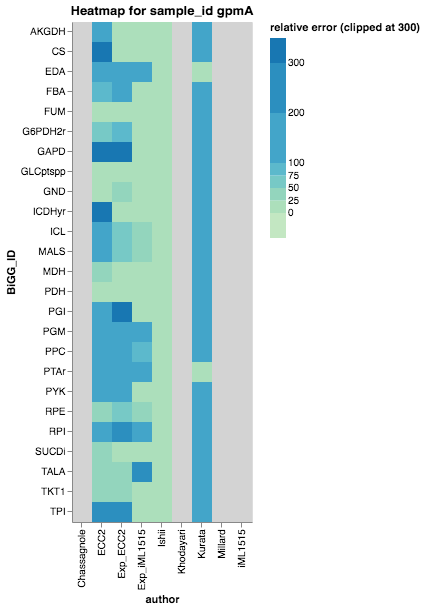

In [16]:
heatmap(x_rel_error, sample_id = "gpmA")

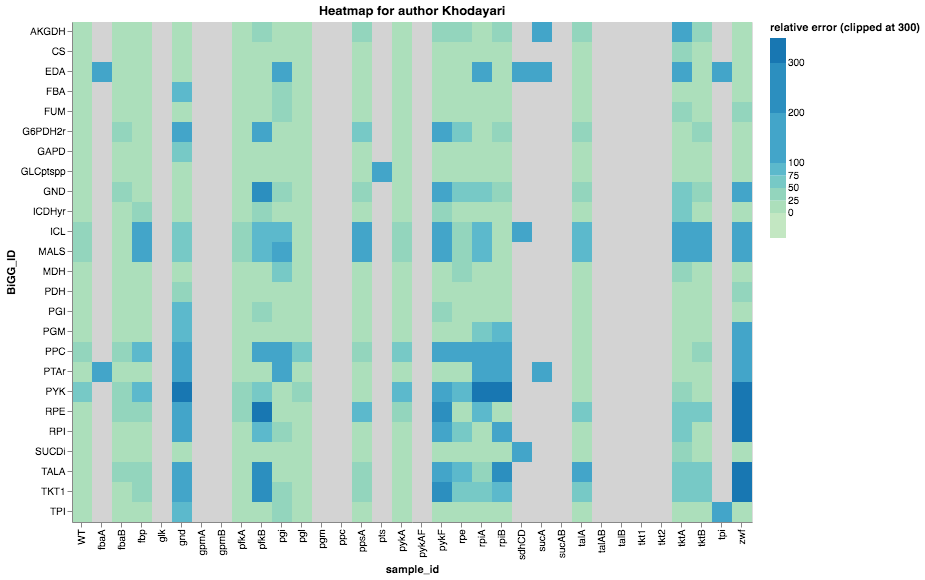

In [17]:
heatmap(x_rel_error, author="Khodayari")

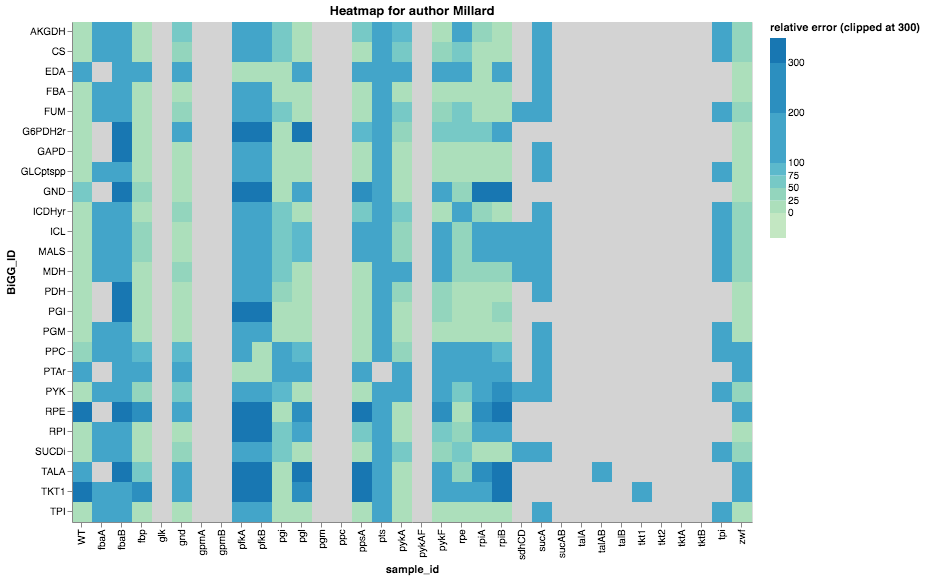

In [18]:
heatmap(x_rel_error, author = "Millard")

In [29]:
kh_wt = x_rel_error.sel(dict(author="Khodayari", sample_id = "WT")).normalized_flux

In [27]:
ex_wt = x_rel_error.sel(dict(author="Ishii", sample_id = "WT")).normalized_flux

In [30]:
ex_wt.sel(BiGG_ID = "PPC")

<xarray.DataArray 'normalized_flux' ()>
array(12.5)
Coordinates:
    sample_id  <U2 'WT'
    author     <U5 'Ishii'
    BiGG_ID    <U3 'PPC'

In [31]:
kh_wt.sel(BiGG_ID = "PPC")

<xarray.DataArray 'normalized_flux' ()>
array(16.880989)
Coordinates:
    sample_id  <U2 'WT'
    author     <U9 'Khodayari'
    BiGG_ID    <U3 'PPC'

In [42]:
ml_wt = x_rel_error.sel(dict(author="Millard", sample_id = "WT")).normalized_flux

In [73]:
print("Normalized flux: Khod -> Millard & Ishii")
iterator = zip(x_rel_error.sel(dict(author="Khodayari", sample_id = "WT")).normalized_flux.values,
               x_rel_error.sel(dict(author="Millard", sample_id = "WT")).normalized_flux.values,
               x_rel_error.sel(dict(author="Ishii", sample_id = "WT")).normalized_flux.values,
               x_rel_error.sel(dict(author="Khodayari", sample_id = "WT")).BiGG_ID.values)
for val1, val2, val3, i in iterator:
    print(f"{i} : {val1:.2f} -> {val2:.2f} & {val3:.2f}")

Normalized flux: Khod -> Millard & Ishii
AKGDH : 55.42 -> 47.56 & 59.00
CS : 89.11 -> 78.44 & 84.50
EDA : 0.00 -> 5.99 & 0.00
FBA : 80.14 -> 82.29 & 86.50
FUM : 80.56 -> 69.40 & 76.00
G6PDH2r : 17.87 -> 16.19 & 16.00
GAPD : 158.70 -> 168.37 & 173.00
GLCptspp : 99.88 -> 100.00 & 100.00
GND : 16.28 -> 10.21 & 16.00
ICDHyr : 76.21 -> 56.60 & 67.50
ICL : 12.13 -> 21.84 & 16.50
MALS : 12.16 -> 21.84 & 16.50
MDH : 87.99 -> 86.59 & 86.50
PDH : 116.37 -> 131.64 & 128.00
PGI : 79.57 -> 82.09 & 82.50
PGM : -153.97 -> 155.85 & 162.00
PPC : 16.88 -> 23.54 & 12.50
PTAr : 0.00 -> 6.85 & 0.00
PYK : 29.11 -> 44.72 & 47.00
RPE : 5.09 -> 0.79 & 5.00
RPI : -11.39 -> 9.41 & 11.00
SUCDi : 82.56 -> 69.40 & 76.00
TALA : 4.23 -> 1.91 & 4.00
TKT1 : 4.14 -> 0.79 & 4.00
TPI : 79.61 -> 82.29 & 86.50


In [70]:
print("Relative error: Khod -> Millard")
iterator = zip(x_rel_error.sel(dict(author="Khodayari", sample_id = "WT")).relative_error.values,
               x_rel_error.sel(dict(author="Millard", sample_id = "WT")).relative_error.values,
               x_rel_error.sel(dict(author="Khodayari", sample_id = "WT")).BiGG_ID.values)
for val1, val2, i in iterator:
    print(f"{i} : {val1:.2f} -> {val2:.2f}")

Relative error: Khod -> Millard
AKGDH : 6.45 -> 24.04
CS : 5.18 -> 7.73
EDA : 0.00 -> 100.00
FBA : 7.94 -> 5.12
FUM : 5.66 -> 9.51
G6PDH2r : 10.48 -> 1.19
GAPD : 9.01 -> 2.75
GLCptspp : 0.12 -> 0.00
GND : 1.73 -> 56.77
ICDHyr : 11.43 -> 19.26
ICL : 36.00 -> 24.45
MALS : 35.71 -> 24.45
MDH : 1.69 -> 0.10
PDH : 9.99 -> 2.77
PGI : 3.68 -> 0.50
PGM : 205.21 -> 3.94
PPC : 25.95 -> 46.89
PTAr : 0.00 -> 100.00
PYK : 61.48 -> 5.10
RPE : 1.83 -> 531.55
RPI : 196.59 -> 16.84
SUCDi : 7.94 -> 9.51
TALA : 5.51 -> 109.82
TKT1 : 3.35 -> 405.24
TPI : 8.66 -> 5.12


# Export the data

In [42]:
path = data_path / "processed"
path.mkdir(parents=True, exist_ok=True)

In [201]:
x_rel_error.to_dataframe().reset_index().to_csv(data_path / "processed" / "ko_relative_errors.csv")

<xarray.Dataset>
Dimensions:          (BiGG_ID: 25, author: 11, sample_id: 22)
Coordinates:
  * sample_id        (sample_id) object 'WT' 'fbaB' 'fbp' ... 'tktB' 'zwf'
  * author           (author) object 'Chassagnole' 'ECC2' ... 'iML1515'
  * BiGG_ID          (BiGG_ID) object 'AKGDH' 'CS' 'EDA' ... 'TALA' 'TKT1' 'TPI'
Data variables:
    flux             (sample_id, author, BiGG_ID) float64 nan nan ... 2.676
    normalized_flux  (sample_id, author, BiGG_ID) float64 0.0 0.0 ... 93.16
    relative_error   (sample_id, author, BiGG_ID) float64 100.0 100.0 ... 0.1711

In [139]:
x_norm_error.to_dataframe().reset_index().to_csv(data_path / "processed" / "ko_summary_errors.csv")